In [1]:
!pip install tensorflow

In [2]:
pip install metatrader5

In [3]:
pip install tf2onnx

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Python libraries
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv

In [5]:
#check tensorflow version
print(tf.__version__)

2.16.1


In [6]:
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

False


In [7]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [8]:
terminal_info=mt5.terminal_info()

In [9]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Files\\"

In [10]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]

In [11]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2024-02-01 00:03:00.548888
data end date= 2024-05-31 00:03:00.548888


In [12]:
#get EURUSD rates (H1) from start_date to end_date
eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, start_date, end_date)

In [13]:
#check
print(eurusd_rates)

[(1706745600, 1.08163, 1.08201, 1.08073, 1.08138,  525, 6, 0)
 (1706749200, 1.08144, 1.08171, 1.08033, 1.0804 , 1148, 0, 0)
 (1706752800, 1.0804 , 1.08146, 1.08019, 1.08084, 2135, 0, 0) ...
 (1717102800, 1.08392, 1.084  , 1.08353, 1.08369, 2234, 0, 0)
 (1717106400, 1.08369, 1.08369, 1.0827 , 1.08303, 2696, 0, 0)
 (1717110000, 1.08303, 1.08327, 1.08291, 1.08321,  949, 0, 0)]


In [14]:
#create dataframe
df = pd.DataFrame(eurusd_rates)

In [15]:
#show dataframe head
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1706745600,1.08163,1.08201,1.08073,1.08138,525,6,0
1,1706749200,1.08144,1.08171,1.08033,1.08040,1148,0,0
2,1706752800,1.08040,1.08146,1.08019,1.08084,2135,0,0
3,1706756400,1.08085,1.08126,1.08046,1.08091,2816,0,0
4,1706760000,1.08090,1.08219,1.08086,1.08194,2645,0,0


In [16]:
#show dataframe tail
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
2059,1717095600,1.08364,1.08422,1.08359,1.08402,2485,0,0
2060,1717099200,1.08401,1.08433,1.08392,1.08392,1972,0,0
2061,1717102800,1.08392,1.08400,1.08353,1.08369,2234,0,0
2062,1717106400,1.08369,1.08369,1.08270,1.08303,2696,0,0
2063,1717110000,1.08303,1.08327,1.08291,1.08321,949,0,0


In [17]:
#show dataframe shape (the number of rows and columns in the data set)
df.shape

(2064, 8)

In [18]:
#prepare close prices only
data = df.filter(['close']).values

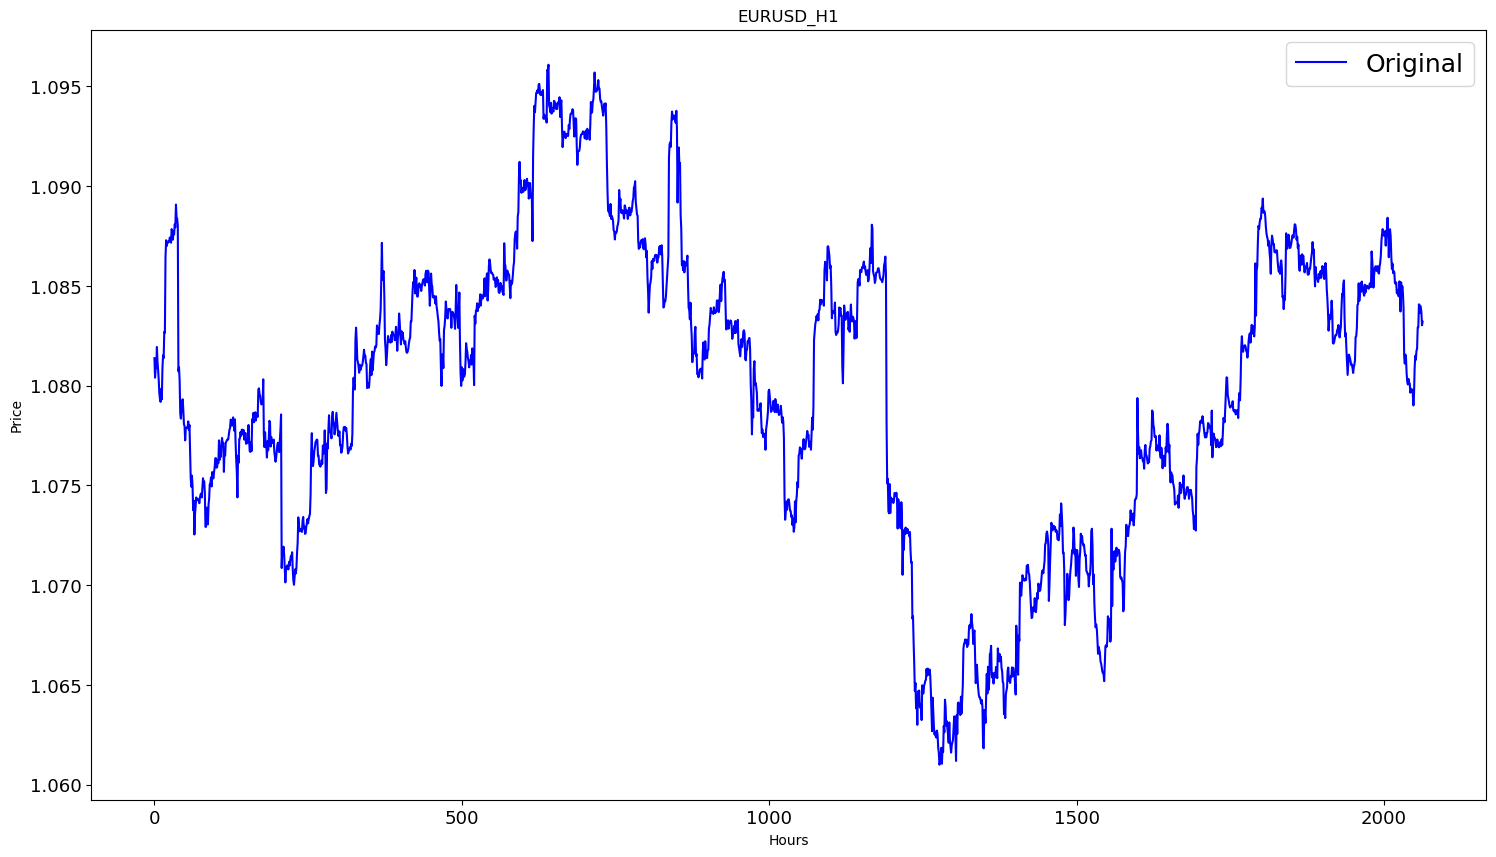

In [19]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.xticks(fontsize=13)
plt.ylabel("Price")
plt.yticks(fontsize=13)
plt.title("EURUSD_H1")
plt.legend(fontsize=18)

In [20]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [21]:
#training size is 80% of the data
training_size = int(len(scaled_data)*0.80) 
print("training size:",training_size)

training size: 1651


In [22]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]
print(len(train_data_initial))

1651


In [23]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

413


In [24]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [25]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

In [26]:
#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [27]:
#show shape of train data
x_train.shape

(1531, 120, 1)

In [28]:
#show shape of test data
x_test.shape

(293, 120, 1)

In [29]:
pip install --upgrade keras

Note: you may need to restart the kernel to use updated packages.


In [30]:
#import keras libraries for the model
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from keras.layers import LSTM
#from keras.utils.vis_utils import plot_model
from keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers

In [31]:
#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = None))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

C:\Users\omaima\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
#show model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 120, 256)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 100)             │         142,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,069 (875.27 KB)

 Trainable params: 224,069 (875.27 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
#measure time
import time 
time_calc_start = time.time()

#fit model with 20 epochs
history=model.fit(x_train,y_train,epochs=20,validation_data=(x_test,y_test),batch_size=32,verbose=1)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - loss: 0.0622 - root_mean_squared_error: 0.2340 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - los

In [34]:
#show training history keys
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

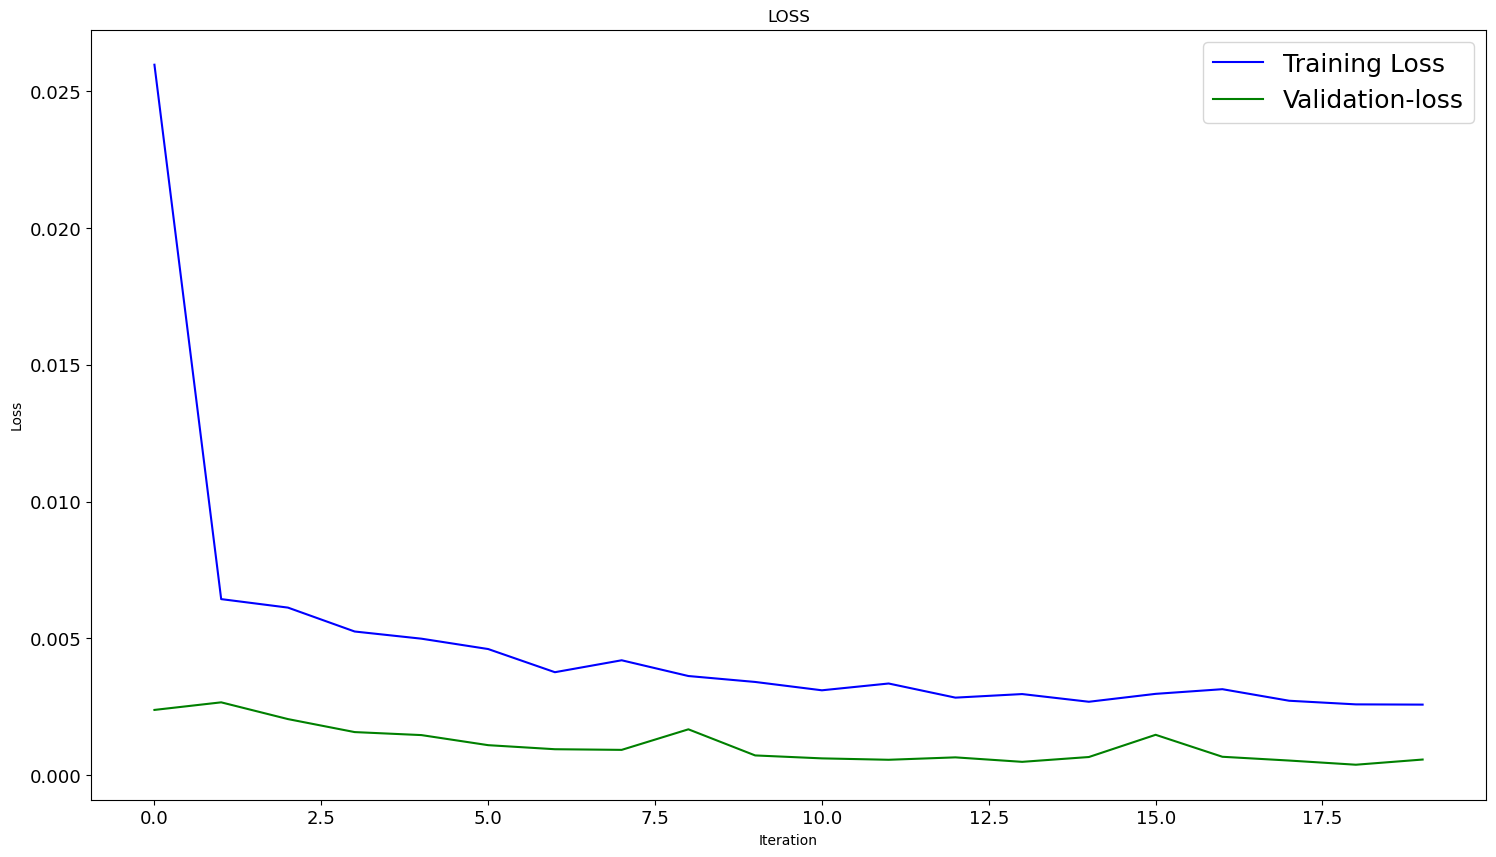

In [35]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("LOSS")
plt.legend(fontsize=18)

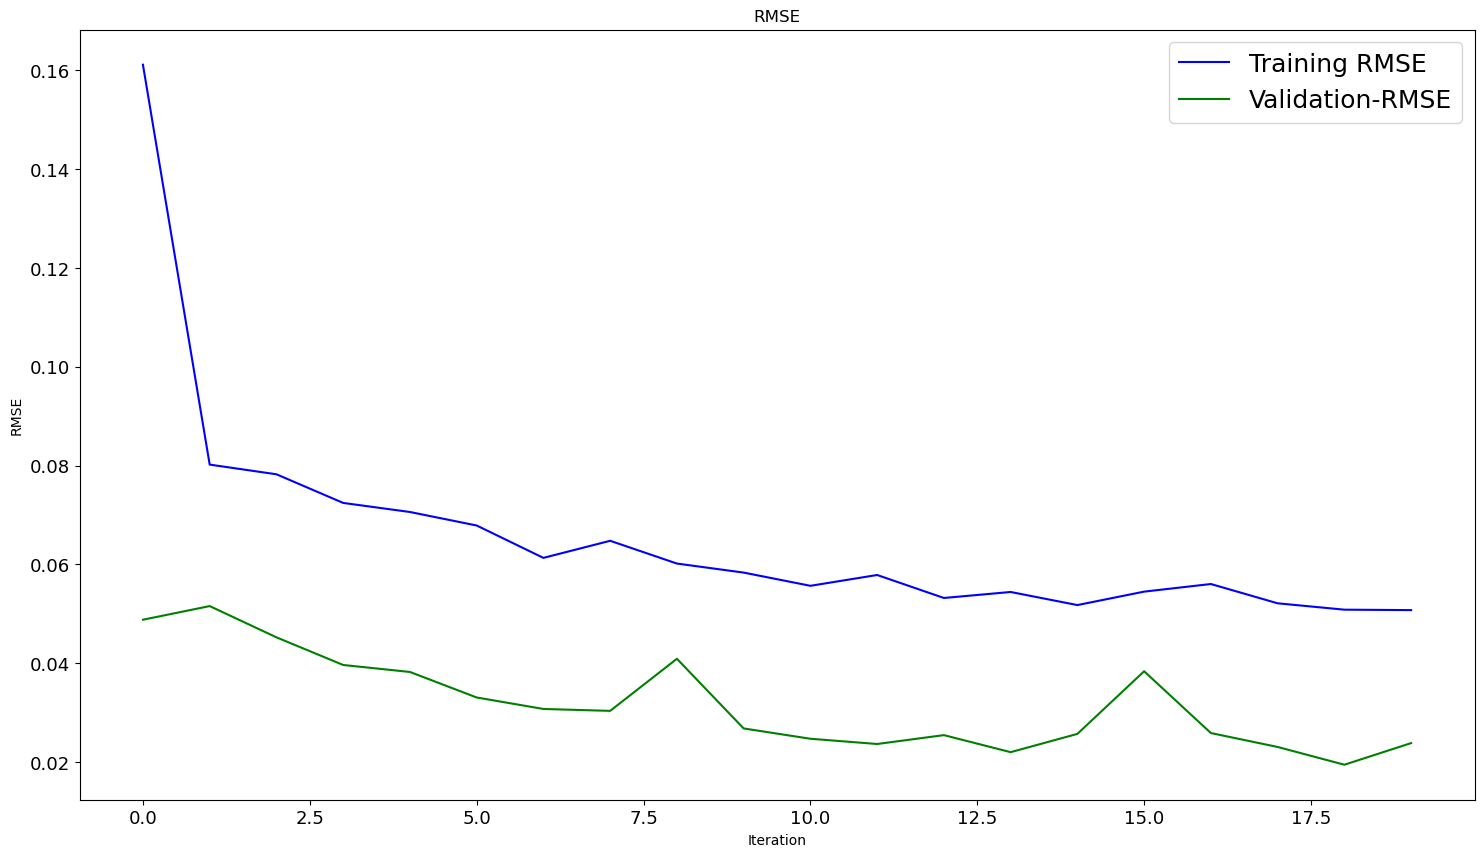

In [36]:
#show iteration-rmse graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE',color='b')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation-RMSE',color='g')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("RMSE")
plt.legend(fontsize=18)

In [37]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.2657e-04 - root_mean_squared_error: 0.0287


[0.0008895288920029998, 0.02982497029006481]

In [38]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.4812e-04 - root_mean_squared_error: 0.0253


[0.0005681498441845179, 0.023835893720388412]

In [39]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


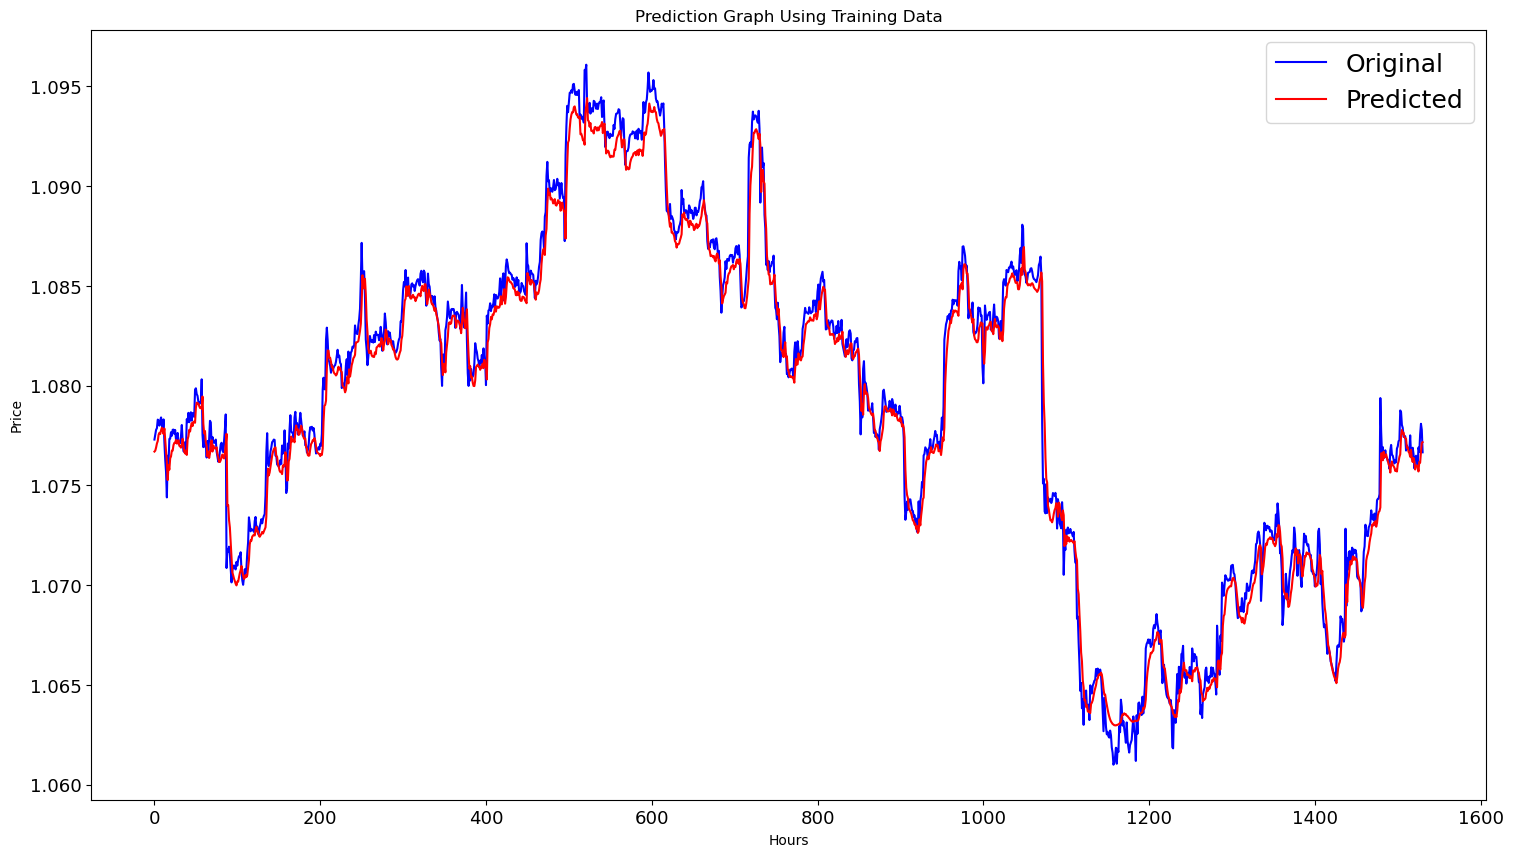

In [40]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [41]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [42]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 0.0008363953114389668
MSE          : 6.995571169970862e-07
R2 score     : 0.8675050549598573


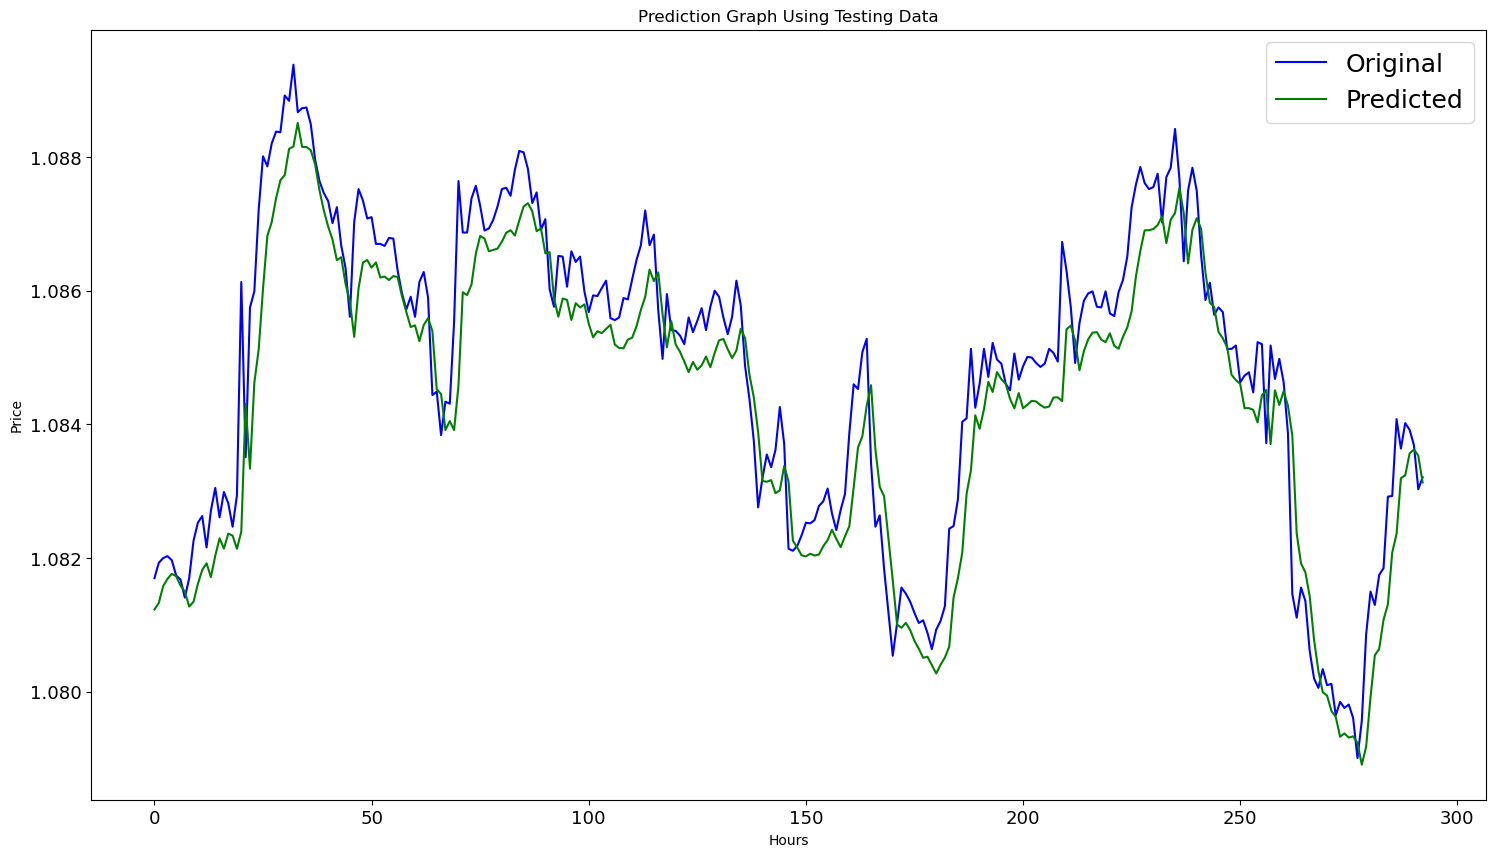

In [43]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [44]:
import pandas as pd 
madusd_data = pd.read_csv(r"C:\Users\omaima\Downloads\HistoricalPrices (1).csv")

In [45]:
madusd_data

,time,open,high,low,close
0,5/20/2024,9.9496,9.9534,9.9171,9.9367
1,5/17/2024,9.9569,9.9853,9.9405,9.9496
2,5/16/2024,9.9623,9.9716,9.9471,9.9559
3,5/15/2024,10.0250,10.0257,9.9594,9.9673
4,5/14/2024,10.0236,10.0362,10.0141,10.0209
...,...,...,...,...,...
356,1/6/2023,10.4273,10.4517,10.3189,10.3353
357,1/5/2023,10.4528,10.4528,10.3761,10.4264
358,1/4/2023,10.5066,10.5140,10.4263,10.4405
359,1/3/2023,10.4499,10.5495,10.4391,10.5065


In [46]:
from sklearn.preprocessing import MinMaxScaler


# Assume 'Close' is the column you want to predict
# and you have other features similar to your training data
# Assuming 'Date' is a column to be dropped and 'Close' is the column to predict
# Preprocess the new data
madusd_data = madusd_data.drop(['time'], axis=1)

# You should use the same scaler used during training
scaler = MinMaxScaler(feature_range=(0, 1))

# Assuming you have the same features as in training
# Scale the data (fit_transform if you have to scale both training and new data together,
# transform only if you are applying the scaler learned from training data)
scaled_data = scaler.fit_transform(madusd_data)

# Prepare the input data
# Assuming your LSTM model expects sequences of a certain length (e.g., 60 timesteps)
sequence_length = 60

X_test = []
for i in range(sequence_length, len(scaled_data)):
    X_test.append(scaled_data[i-sequence_length:i, :])

X_test = np.array(X_test)


# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual price values
# Create a placeholder for inverse transformation with the same number of features
# Here, we assume only the last feature 'Close' was predicted
predicted_close_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((predictions.shape[0], scaled_data.shape[1] - 1)), predictions), axis=1)
)[:, -1]

# Create a dataframe to store the results
predicted_data = pd.DataFrame(predicted_close_prices, columns=['Predicted_Close'])

# Save the predictions to a CSV file (optional)
#predicted_data.to_csv('madusd_predictions.csv', index=False)

print(predicted_data)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
     Predicted_Close
0          10.069124
1          10.065067
2          10.062728
3          10.064805
4          10.074767
..               ...
296        10.240020
297        10.322663
298        10.374196
299        10.426560
300        10.456434

[301 rows x 1 columns]


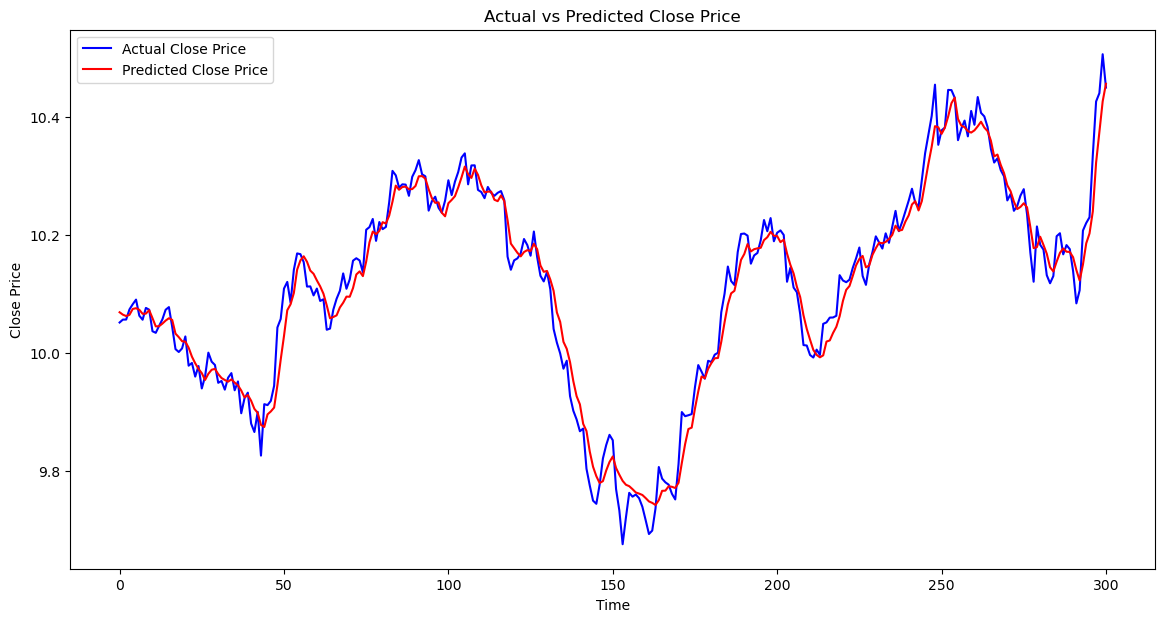

In [47]:
actual_close_prices = madusd_data['close'].values
# Create a dataframe to store the results for plotting
results = pd.DataFrame({
    'Actual_Close': actual_close_prices[sequence_length:],  # Only the part used for prediction
    'Predicted_Close': predicted_close_prices
})

# Plot the actual vs predicted close prices
plt.figure(figsize=(14, 7))
plt.plot(results['Actual_Close'], color='blue', label='Actual Close Price')
plt.plot(results['Predicted_Close'], color='red', label='Predicted Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [48]:
# save model to ONNX
#output_path = data_path+"model.eurusd.H1.120.onnx"
#onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)

In [49]:
# finish
mt5.shutdown()

True